[False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, T

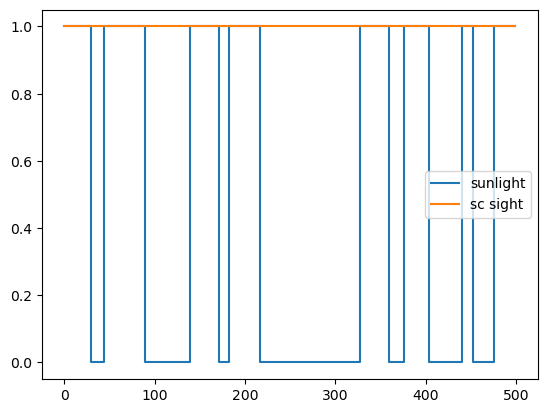

In [3]:
import numpy as np

# Problem parameters
repeats = 5
N = 100 * repeats
sun_light = [False] * 10 + [True] * 10 + [False] * 100 + [True] * 50 + [False] * 10 + [True] * 150
print(sun_light)
sun_light = []
while len(sun_light) < N:
    state = np.random.choice([True, False])
    time = np.random.normal(20, 10)
    if time <= 0:
        continue
    sun_light.extend([state] * int(time))
sun_light = sun_light[:N]
los_sc = np.tile(np.array([False] * 10 + [True] * 10), 5 * repeats)
los_sc = [True] * N * repeats
los_sc = los_sc[:N]
Rsc = 0.5
Rdl = 3.0

import matplotlib.pyplot as plt
plt.step(range(N), sun_light, label='sunlight')
plt.step(range(N), los_sc, label='sc sight')
plt.legend()
plt.show()

In [ ]:
import cvxpy as cp

# Decision variables
T_sc = cp.Variable(N, boolean=True)
T_dl = cp.Variable(N, boolean=True)
T_idle = cp.Variable(N, boolean=True)

dl_sum = cp.Variable(N)
sc_sum = cp.Variable(N)

# Constraints list
constraints = []

# Constraint 1: Must collect data when there is sunligt
for t in range(N):
    constraints += [T_sc[t] <= sun_light[t]]

# Constraint 2: Only one variable avaiable at each time step
constraints += [(T_sc[t] + T_dl[t] + T_idle[t] == 1) for t in range(N)]

# Constraint 3: We cannot transmit what we have not scienced
for t in range(N):
    constraints += [
        cp.sum(T_dl[:t + 1]) * Rdl <= cp.sum(T_sc[:t + 1]) * Rsc
    ]

# Constraint 4: At the end we must transmit approximately what we science
summ_diff = 5
constraints += [cp.abs((cp.sum(T_sc) * Rsc) - (cp.sum(T_dl) * Rdl)) <= summ_diff]

for t in range(N):
    constraints += [T_dl[t] <= los_sc[t]]

buffer_size = 200
# Constraint 5: Buffer size must not be exceeded
for t in range(N):
    constraints += [
        (cp.sum(T_sc[:t + 1]) * Rsc - cp.sum(T_dl[:t + 1]) * Rdl) <= buffer_size
    ]

M = 50
# Ground station cappin
rising_edges = cp.Variable(N, boolean=True)
falling_edges = cp.Variable(N, boolean=True)
GS = cp.Variable(N, boolean=True)

for t in range(1, N-M):
    constraints += [rising_edges[t-1] >= T_dl[t] - T_dl[t-1]]

    constraints += [falling_edges[t-1+M] == rising_edges[t-1]]

    constraints += [GS[t] == cp.sum(rising_edges[:t]) - cp.sum(falling_edges[:t])]

    constraints += [T_dl[t] <= GS[t]]

for t in range(N-M, N):
    constraints += [rising_edges[t] == False]
    
    constraints += [GS[t] == cp.sum(rising_edges[:t]) - cp.sum(falling_edges[:t])]
    
    constraints += [T_dl[t] <= GS[t]]

# constraints += [cp.sum(Tg[t:t+M]) == M if (GS[t] == 1) for t in range(N)]
# M = 10
# constraints += [(GS[t] == 1, GS[t + M] == -1, GS[t + M] == 0) for t in range(N - M)]
# constraints += [T_dl[t] <= Tg[t] for t in range(N)]
# constraints += [Tg[t] <= cp.sum(GS[t])]
# constraints += [cp.sum(Tg) == 0]
# constraints += [cp.sum(Tg[t:t+M]) == M for t in range(N-M)]

# Objective: minimize total downlink usage
objective = cp.Minimize(cp.sum(rising_edges))
objective = cp.Maximize(cp.sum(T_sc * Rsc))
# Solve
problem = cp.Problem(objective, constraints)
print(cp.installed_solvers())

# Ensure the CBC solver is installed
problem.solve(solver=cp.GLPK_MI)  # Using the CBC solver as an alternative

# Output
print("Status:", problem.status)
print("Total cost (timeslots slots used):", problem.value)
print("Total cost (downlink slots used):", sum(T_dl.value))
print("Total downlined:", sum(T_dl.value) * Rdl)
print("Total scienced:", sum(T_sc.value) * Rsc)
for t in range(N):
    print(f"t={t}: T_sc={T_sc.value[t]:.0f}, T_dl={T_dl.value[t]:.0f}, T_idle={T_idle.value[t]:.0f}, GS={GS.value[t]}")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']


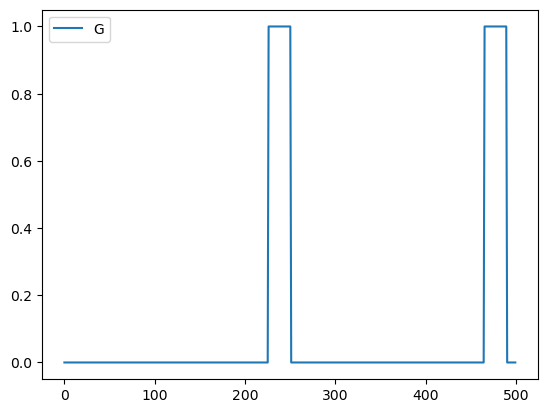

In [48]:
import matplotlib.pyplot as plt
import numpy as np
g = np.empty(N, np.float16)
tg = np.empty(N,np.float16)
for t in range(1,N):
    g[t] = GS.value[t]
plt.plot(g, label = 'G')
plt.legend()
plt.show()

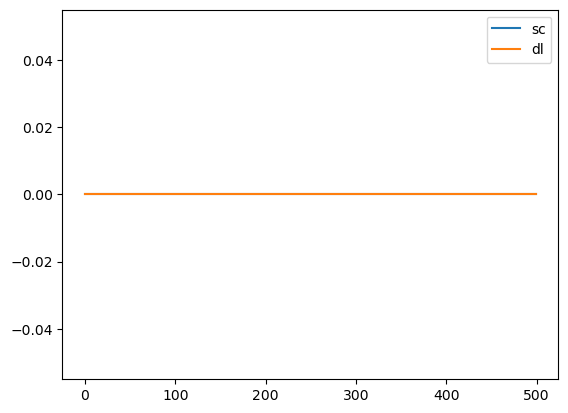

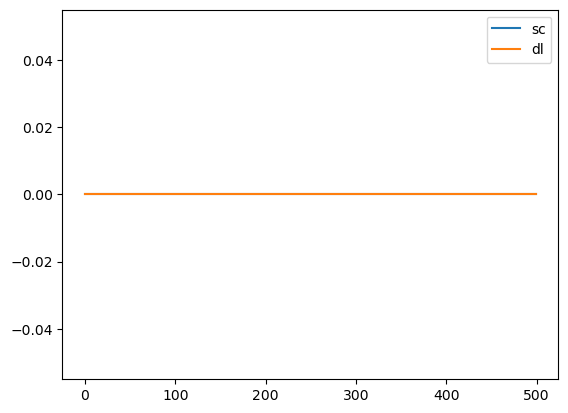

In [52]:

sc = np.empty(N, np.float16)
dl = np.empty(N, np.float16)
for t in range(N):
    sc[t] = T_sc.value[t]
    dl[t] = T_dl.value[t]  # Extract values from T_dl
sc_cumsum = np.cumsum(sc*Rsc)
dl_cumsum = np.cumsum(dl*Rdl)

plt.step(range(N), sc, label = 'sc')
plt.step(range(N), dl, label = 'dl')
plt.legend()
plt.show()
plt.step(range(N), sc_cumsum, label = 'sc')
plt.step(range(N), dl_cumsum, label = 'dl')
plt.legend()
plt.show()

In [80]:
atoms = problem.atoms()
for a in atoms:
    print(a)
constrain = problem.constraints
for c in constrain:
    print(c)

<class 'cvxpy.atoms.affine.sum.Sum'>
<class 'cvxpy.atoms.affine.index.index'>
<class 'cvxpy.atoms.affine.add_expr.AddExpression'>
<class 'cvxpy.atoms.affine.binary_operators.multiply'>
<class 'cvxpy.atoms.affine.promote.Promote'>
<class 'cvxpy.atoms.affine.unary_operators.NegExpression'>
var367761[0] == 0.0
var367761[1] == 0.0
var367761[2] == 0.0
var367761[3] == 0.0
var367761[4] == 0.0
var367761[5] == 0.0
var367761[6] == 0.0
var367761[7] == 0.0
var367761[8] == 0.0
var367761[9] == 0.0
var367761[10] == 1.0
var367761[11] == 1.0
var367761[12] == 1.0
var367761[13] == 1.0
var367761[14] == 1.0
var367761[15] == 1.0
var367761[16] == 1.0
var367761[17] == 1.0
var367761[18] == 1.0
var367761[19] == 1.0
var367761[20] == 1.0
var367761[21] == 1.0
var367761[22] == 1.0
var367761[23] == 1.0
var367761[24] == 1.0
var367761[25] == 1.0
var367761[26] == 1.0
var367761[27] == 1.0
var367761[28] == 1.0
var367761[29] == 1.0
var367761[30] == 0.0
var367761[31] == 0.0
var367761[32] == 0.0
var367761[33] == 0.0
var3677